This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp


WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll

# Perturbing enzymes

In [3]:
pt_levels= np.logspace(-1, 0, num=20)
pt_levels = pt_levels.round(3)
pt_levels

array([0.1  , 0.113, 0.127, 0.144, 0.162, 0.183, 0.207, 0.234, 0.264,
       0.298, 0.336, 0.379, 0.428, 0.483, 0.546, 0.616, 0.695, 0.785,
       0.886, 1.   ])

In [4]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/enzymeCompilation.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [5]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

In [6]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [7]:
with pymc_model:
    
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BIOMD64.en.T)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)


In [8]:
with pymc_model:
    
    likelihood = pm.Deterministic('vn', e_obs * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [9]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.439e+05
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


In [11]:
# takig the median peaks can only be done if the distributions are unimodal!
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_trace.shape

(17, 14, 1000)

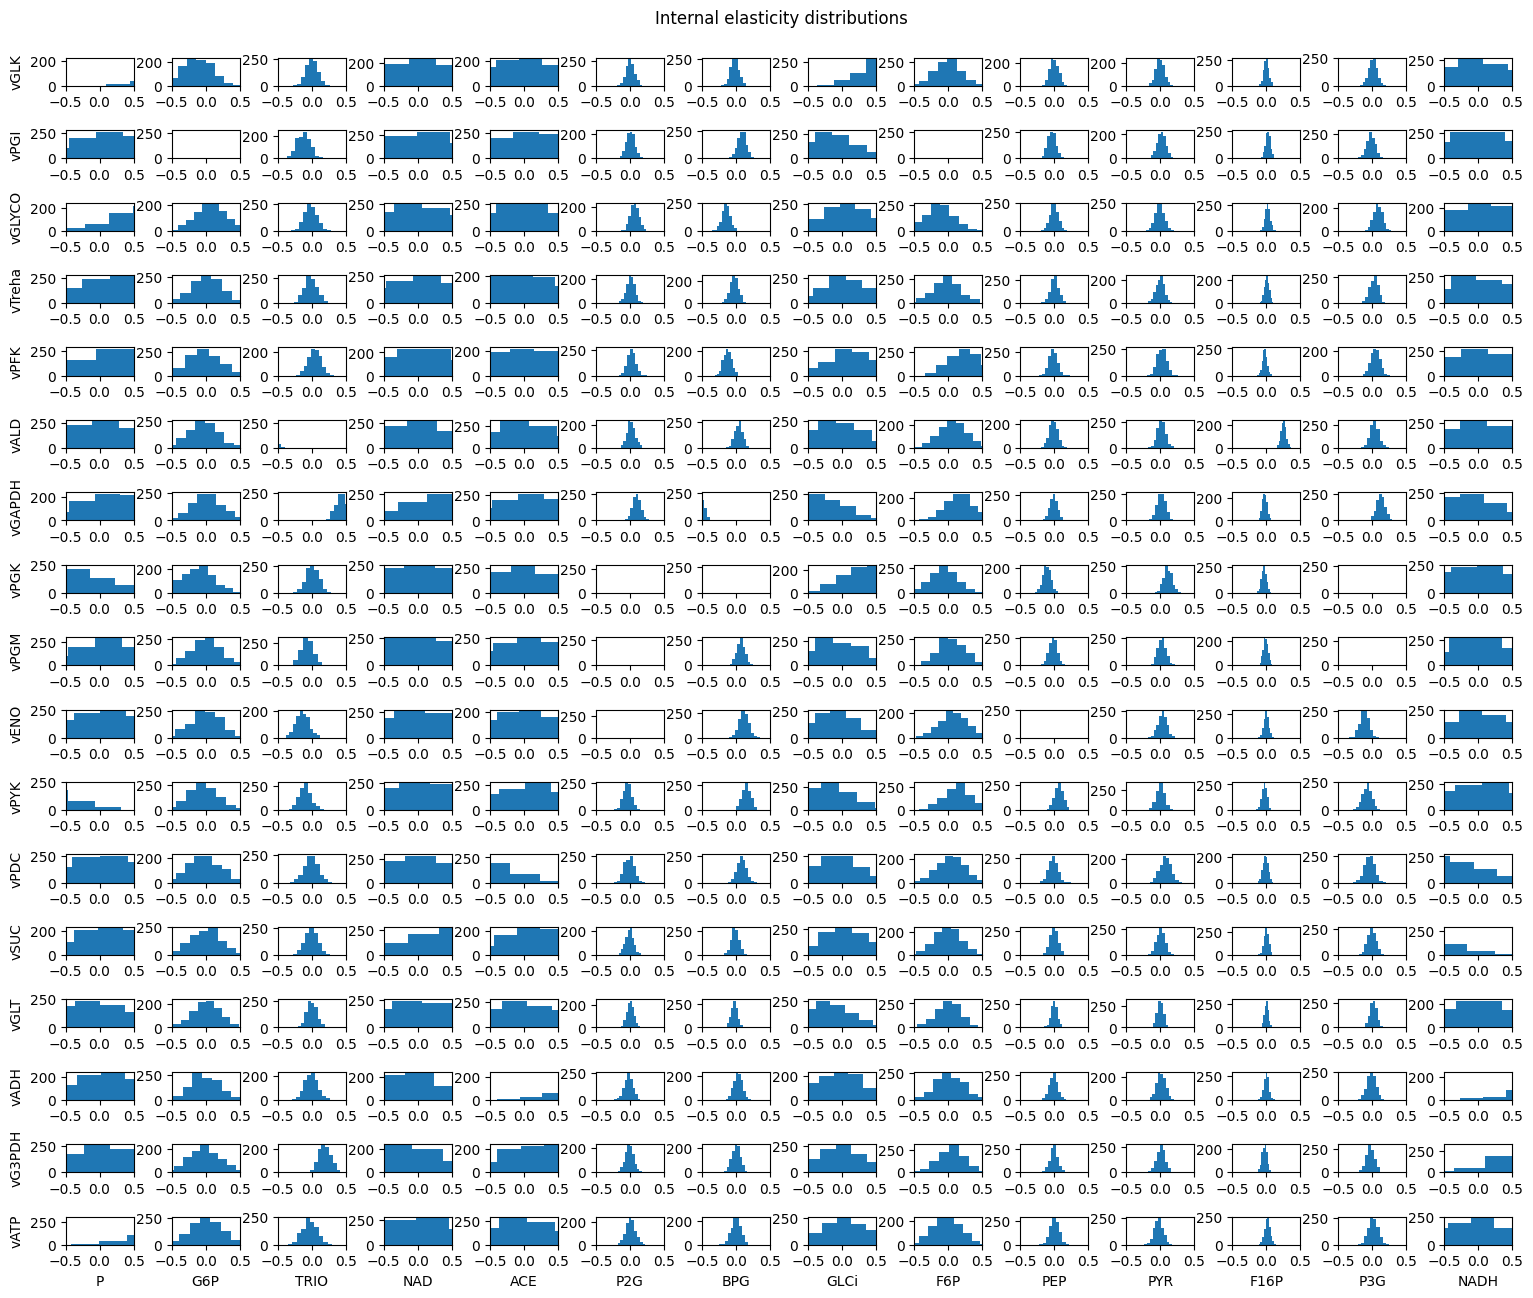

In [12]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

In [13]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [14]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

,P,G6P,TRIO,NAD,ACE,P2G,BPG,GLCi,F6P,PEP,PYR,F16P,P3G,NADH
vGLK,1.758171,-0.125498,0.000000,0.000000,-0.034188,0.000000,-0.017200,0.604206,0.000000,0.000000,0.000000,0.000000,0.000000,0.018304
vPGI,0.147982,1.961485,-0.110417,0.031702,0.035050,0.000000,0.089560,-0.184377,-1.566523,-0.032191,0.020539,0.023938,-0.020954,0.000000
vGLYCO,0.919755,0.075446,-0.021552,0.000000,-0.041242,0.067722,-0.142722,0.089217,-0.124628,0.000000,0.000000,0.017818,0.077743,0.016197
vTreha,0.199921,0.029491,-0.015398,0.045085,0.000000,0.013377,-0.026747,0.035751,-0.015778,0.000000,0.000000,0.000000,0.028675,0.000000
vPFK,0.379990,-0.023290,0.046520,0.028161,0.028926,0.024771,-0.120952,0.132115,0.250508,-0.013970,0.023879,-0.024724,0.041919,0.000000
vALD,0.067520,-0.042157,-0.666876,-0.051746,0.000000,0.018609,0.045023,-0.099609,0.080624,-0.010288,0.020322,0.253792,0.028906,0.000000
vGAPDH,0.279960,0.018011,0.441238,0.443859,0.062770,0.097178,-0.527827,-0.313944,0.171339,0.000000,0.011913,-0.023956,0.124422,-0.248402
vPGK,-0.591923,-0.106435,0.013053,-0.053740,-0.017860,0.714292,0.932993,0.369909,-0.059375,-0.105912,0.108333,-0.034524,-1.616733,-0.021801
vPGM,0.145545,0.000000,-0.067880,-0.050504,0.089767,-0.910745,0.074064,-0.089926,0.047699,-0.016004,0.024183,-0.011512,0.899653,0.000000
vENO,0.089787,0.000000,-0.138370,0.000000,0.000000,0.833921,0.118784,-0.125310,0.075621,-0.676873,0.033927,0.000000,-0.121507,0.015122


In [15]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

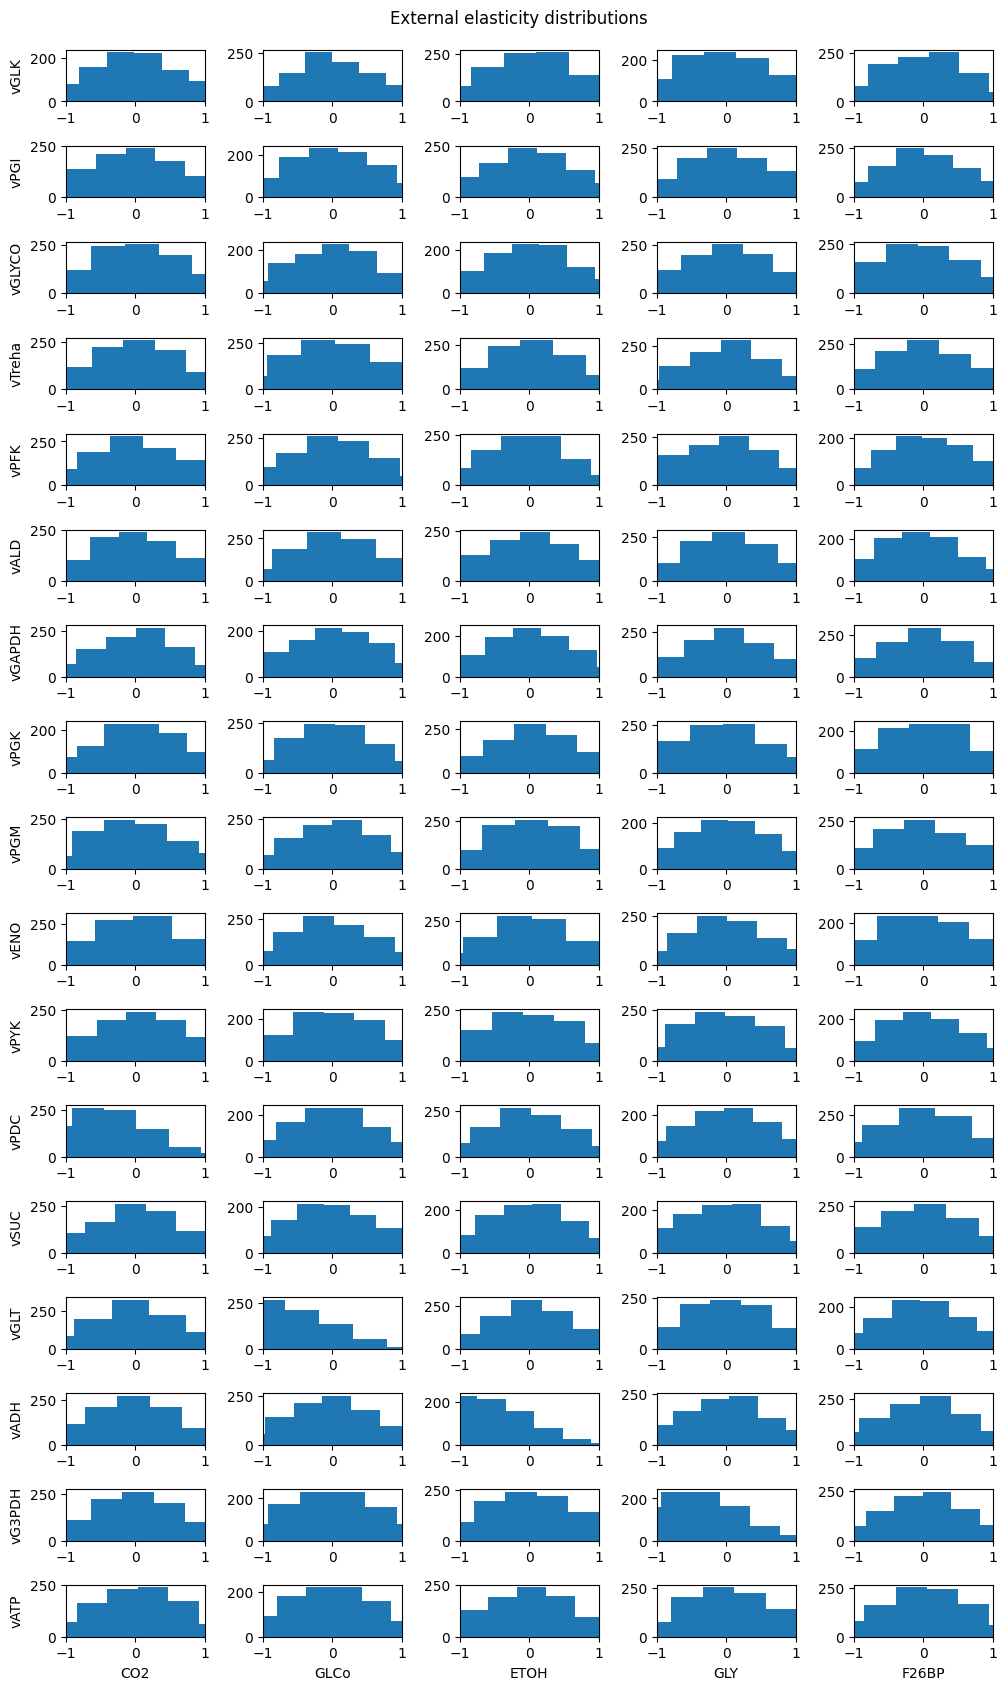

In [16]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-1,1])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [17]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [18]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

,CO2,GLCo,ETOH,GLY,F26BP
vGLK,-0.020395,-0.033973,0.010411,-0.042052,0.000000
vPGI,0.000000,0.013050,0.000000,0.000000,-0.011056
vGLYCO,0.000000,0.029498,0.056275,-0.014028,-0.026575
vTreha,0.000000,-0.014166,0.000000,0.046361,-0.024260
vPFK,-0.015550,0.000000,-0.039776,0.000000,0.018694
vALD,-0.034471,0.029658,0.000000,0.057184,-0.075895
vGAPDH,0.050455,0.037733,0.013519,0.018344,-0.020776
vPGK,0.020920,0.000000,0.030850,-0.029877,0.044289
vPGM,-0.047420,0.036969,0.025211,0.000000,-0.057600
vENO,0.011623,-0.021535,-0.011735,-0.034554,-0.051357


In [19]:
enzymes = [i for i in data.columns if 'e_' in i]

In [20]:
a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]

a = data[data[enzymes] != 1].values.flatten()
pt_lvls = a[~np.isnan(a)]

C:\Users\user\AppData\Local\Temp\ipykernel_13112\1020810182.py:2: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [21]:
# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [22]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = enzPtLvls
rel_real_values

,e_vGLK|0.9,e_vGLK|1.1,e_vPGI|0.9,e_vPGI|1.1,e_vGLYCO|0.9,e_vGLYCO|1.1,e_vTreha|0.9,e_vTreha|1.1,e_vPFK|0.9,e_vPFK|1.1,e_vALD|0.9,e_vALD|1.1,e_vGAPDH|0.9,e_vGAPDH|1.1,e_vPGK|0.9,e_vPGK|1.1,e_vPGM|0.9,e_vPGM|1.1,e_vENO|0.9,e_vENO|1.1,e_vPYK|0.9,e_vPYK|1.1,e_vPDC|0.9,e_vPDC|1.1,e_vSUC|0.9,e_vSUC|1.1,e_vGLT|0.9,e_vGLT|1.1,e_vADH|0.9,e_vADH|1.1,e_vG3PDH|0.9,e_vG3PDH|1.1,e_vATP|0.9,e_vATP|1.1,e_vGLK|0.887,e_vGLK|1.113,e_vPGI|0.887,e_vPGI|1.113,e_vGLYCO|0.887,e_vGLYCO|1.113,e_vTreha|0.887,e_vTreha|1.113,e_vPFK|0.887,e_vPFK|1.113,e_vALD|0.887,e_vALD|1.113,e_vGAPDH|0.887,e_vGAPDH|1.113,e_vPGK|0.887,e_vPGK|1.113,e_vPGM|0.887,e_vPGM|1.113,e_vENO|0.887,e_vENO|1.113,e_vPYK|0.887,e_vPYK|1.113,e_vPDC|0.887,e_vPDC|1.113,e_vSUC|0.887,e_vSUC|1.113,e_vGLT|0.887,e_vGLT|1.113,e_vADH|0.887,e_vADH|1.113,e_vG3PDH|0.887,e_vG3PDH|1.113,e_vATP|0.887,e_vATP|1.113,e_vGLK|0.873,e_vGLK|1.127,e_vPGI|0.873,e_vPGI|1.127,e_vGLYCO|0.873,e_vGLYCO|1.127,e_vTreha|0.873,e_vTreha|1.127,e_vPFK|0.873,e_vPFK|1.127,e_vALD|0.873,e_vALD|1.127,e_vGAPDH|0.873,e_vGAPDH|1.127,e_vPGK|0.873,e_vPGK|1.127,e_vPGM|0.873,e_vPGM|1.127,e_vENO|0.873,e_vENO|1.127,e_vPYK|0.873,e_vPYK|1.127,e_vPDC|0.873,e_vPDC|1.127,e_vSUC|0.873,e_vSUC|1.127,e_vGLT|0.873,e_vGLT|1.127,e_vADH|0.873,e_vADH|1.127,e_vG3PDH|0.873,e_vG3PDH|1.127,e_vATP|0.873,e_vATP|1.127,e_vGLK|0.856,e_vGLK|1.144,e_vPGI|0.856,e_vPGI|1.144,e_vGLYCO|0.856,e_vGLYCO|1.144,e_vTreha|0.856,e_vTreha|1.144,e_vPFK|0.856,e_vPFK|1.144,e_vALD|0.856,e_vALD|1.144,e_vGAPDH|0.856,e_vGAPDH|1.144,e_vPGK|0.856,e_vPGK|1.144,e_vPGM|0.856,e_vPGM|1.144,e_vENO|0.856,e_vENO|1.144,e_vPYK|0.856,e_vPYK|1.144,e_vPDC|0.856,e_vPDC|1.144,e_vSUC|0.856,e_vSUC|1.144,e_vGLT|0.856,e_vGLT|1.144,e_vADH|0.856,e_vADH|1.144,e_vG3PDH|0.856,e_vG3PDH|1.144,e_vATP|0.856,e_vATP|1.144,e_vGLK|0.838,e_vGLK|1.162,e_vPGI|0.838,e_vPGI|1.162,e_vGLYCO|0.838,e_vGLYCO|1.162,e_vTreha|0.838,e_vTreha|1.162,e_vPFK|0.838,e_vPFK|1.162,e_vALD|0.838,e_vALD|1.162,e_vGAPDH|0.838,e_vGAPDH|1.162,e_vPGK|0.838,e_vPGK|1.162,e_vPGM|0.838,e_vPGM|1.162,e_vENO|0.838,e_vENO|1.162,e_vPYK|0.838,e_vPYK|1.162,e_vPDC|0.838,e_vPDC|1.162,e_vSUC|0.838,e_vSUC|1.162,e_vGLT|0.838,e_vGLT|1.162,e_vADH|0.838,e_vADH|1.162,e_vG3PDH|0.838,e_vG3PDH|1.162,e_vATP|0.838,e_vATP|1.162,e_vGLK|0.817,e_vGLK|1.183,e_vPGI|0.817,e_vPGI|1.183,e_vGLYCO|0.817,e_vGLYCO|1.183,e_vTreha|0.817,e_vTreha|1.183,e_vPFK|0.817,e_vPFK|1.183,e_vALD|0.817,e_vALD|1.183,e_vGAPDH|0.817,e_vGAPDH|1.183,e_vPGK|0.817,e_vPGK|1.183,e_vPGM|0.817,e_vPGM|1.183,e_vENO|0.817,e_vENO|1.183,e_vPYK|0.817,e_vPYK|1.183,e_vPDC|0.817,e_vPDC|1.183,e_vSUC|0.817,e_vSUC|1.183,e_vGLT|0.817,e_vGLT|1.183,e_vADH|0.817,e_vADH|1.183,e_vG3PDH|0.817,e_vG3PDH|1.183,e_vATP|0.817,e_vATP|1.183,e_vGLK|0.793,e_vGLK|1.207,e_vPGI|0.793,e_vPGI|1.207,e_vGLYCO|0.793,e_vGLYCO|1.207,e_vTreha|0.793,e_vTreha|1.207,e_vPFK|0.793,e_vPFK|1.207,e_vALD|0.793,e_vALD|1.207,e_vGAPDH|0.793,e_vGAPDH|1.207,e_vPGK|0.793,e_vPGK|1.207,e_vPGM|0.793,e_vPGM|1.207,e_vENO|0.793,e_vENO|1.207,e_vPYK|0.793,e_vPYK|1.207,e_vPDC|0.793,e_vPDC|1.207,e_vSUC|0.793,e_vSUC|1.207,e_vGLT|0.793,e_vGLT|1.207,e_vADH|0.793,e_vADH|1.207,e_vG3PDH|0.793,e_vG3PDH|1.207,e_vATP|0.793,e_vATP|1.207,e_vGLK|0.766,e_vGLK|1.234,e_vPGI|0.766,e_vPGI|1.234,e_vGLYCO|0.766,e_vGLYCO|1.234,e_vTreha|0.766,e_vTreha|1.234,e_vPFK|0.766,e_vPFK|1.234,e_vALD|0.766,e_vALD|1.234,e_vGAPDH|0.766,e_vGAPDH|1.234,e_vPGK|0.766,e_vPGK|1.234,e_vPGM|0.766,e_vPGM|1.234,e_vENO|0.766,e_vENO|1.234,e_vPYK|0.766,e_vPYK|1.234,e_vPDC|0.766,e_vPDC|1.234,e_vSUC|0.766,e_vSUC|1.234,e_vGLT|0.766,e_vGLT|1.234,e_vADH|0.766,e_vADH|1.234,e_vG3PDH|0.766,e_vG3PDH|1.234,e_vATP|0.766,e_vATP|1.234,e_vGLK|0.736,e_vGLK|1.264,e_vPGI|0.736,e_vPGI|1.264,e_vGLYCO|0.736,e_vGLYCO|1.264,e_vTreha|0.736,e_vTreha|1.264,e_vPFK|0.736,e_vPFK|1.264,e_vALD|0.736,e_vALD|1.264,e_vGAPDH|0.736,e_vGAPDH|1.264,e_vPGK|0.736,e_vPGK|1.264,e_vPGM|0.736,e_vPGM|1.264,e_vENO|0.736,e_vENO|1.264,e_vPYK|0.736,e_vPYK|1.264,e_vPDC|0.736,e_vPDC|1.264,e_vSUC|0.736,e_vSUC|1.264,e_vGLT|0.736,e_vGLT|1.264,e_vADH|0.736,e_vADH|1.264,e

Text(-9, 4, 'r = 0.532')

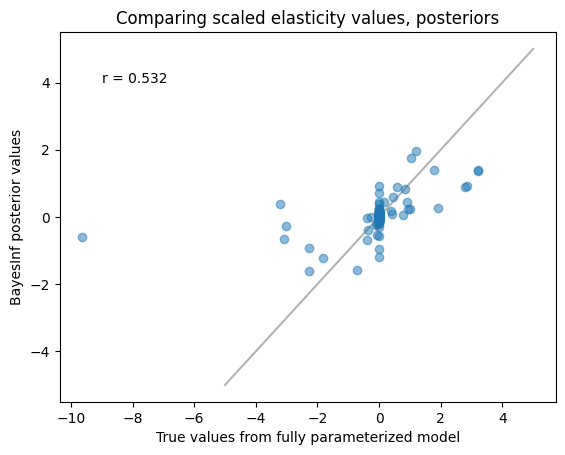

In [24]:
plt.scatter(r.getScaledElasticityMatrix(), x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(r.getScaledElasticityMatrix().flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [25]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [31]:
visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
visFCC.columns = r.getReactionIds()
visFCC.index = r.getReactionIds()
visFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.139587,0.079511,0.031414,0.028661,0.079511,0.079511,0.077840,0.077840,0.077840,0.077840,0.077840,0.077840,0.000836,0.139587,0.077004,0.001671,-0.124330
vPGI,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vGLYCO,0.546373,-0.141574,0.814264,-0.126317,-0.141574,-0.141574,0.095007,0.095007,0.095007,0.095007,0.095007,0.095007,-0.118290,0.546373,0.213298,-0.236581,-0.784441
vTreha,0.546373,-0.141574,-0.185736,0.873683,-0.141574,-0.141574,0.095007,0.095007,0.095007,0.095007,0.095007,0.095007,-0.118290,0.546373,0.213298,-0.236581,-0.784441
vPFK,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vALD,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vGAPDH,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vPGK,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vPGM,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vENO,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089


In [26]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.406619,0.029284,0.000273,0.003691,-0.187115,0.048365,0.175295,0.021710,0.052959,0.037870,0.387078,-0.082690,-0.058207,0.334238,-0.092266,0.045229,-0.122333
vPGI,0.470743,0.036686,-0.077262,-0.058109,-0.206428,0.052374,0.182575,0.006952,0.037434,0.041880,0.404026,-0.061347,-0.055798,0.392535,-0.079088,0.043166,-0.130338
vGLYCO,-0.115911,-0.032914,1.014166,0.013227,-0.011432,0.022214,0.162465,0.185707,0.246989,0.017053,0.435747,-0.353893,-0.100287,-0.231353,-0.282059,0.096995,-0.066713
vTreha,0.026467,-0.012248,-0.017654,0.987662,-0.095498,0.016440,0.074009,0.054519,0.060594,-0.000723,0.053143,-0.087615,-0.044426,0.101806,-0.067388,0.013766,-0.062855
vPFK,0.470743,0.036686,-0.077262,-0.058109,-0.206428,0.052374,0.182575,0.006952,0.037434,0.041880,0.404026,-0.061347,-0.055798,0.392535,-0.079088,0.043166,-0.130338
vALD,0.470743,0.036686,-0.077262,-0.058109,-0.206428,0.052374,0.182575,0.006952,0.037434,0.041880,0.404026,-0.061347,-0.055798,0.392535,-0.079088,0.043166,-0.130338
vGAPDH,0.496294,0.039229,-0.067218,-0.050880,-0.254953,0.054628,0.238799,0.015384,0.053128,0.048863,0.481519,-0.058653,-0.093433,0.278644,-0.068421,-0.010988,-0.101941
vPGK,0.496294,0.039229,-0.067218,-0.050880,-0.254953,0.054628,0.238799,0.015384,0.053128,0.048863,0.481519,-0.058653,-0.093433,0.278644,-0.068421,-0.010988,-0.101941
vPGM,0.496294,0.039229,-0.067218,-0.050880,-0.254953,0.054628,0.238799,0.015384,0.053128,0.048863,0.481519,-0.058653,-0.093433,0.278644,-0.068421,-0.010988,-0.101941
vENO,0.496294,0.039229,-0.067218,-0.050880,-0.254953,0.054628,0.238799,0.015384,0.053128,0.048863,0.481519,-0.058653,-0.093433,0.278644,-0.068421,-0.010988,-0.101941


Text(-4, 4, 'r = 0.751')

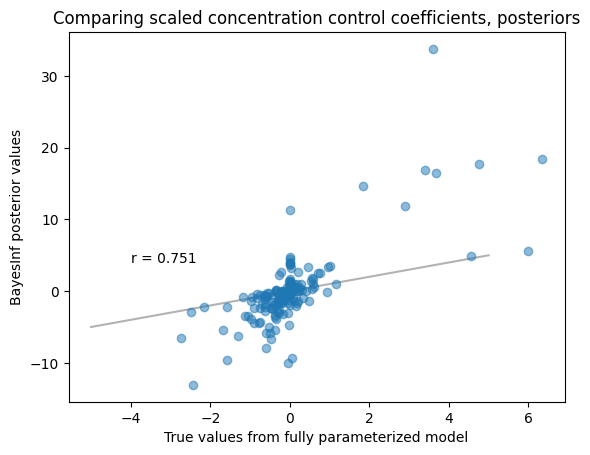

In [27]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = 0.503')

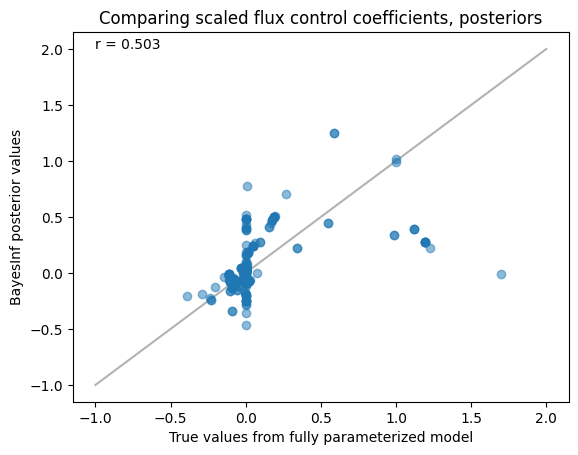

In [28]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

## Pairwise comparison of FCC values

In [29]:
def plot_pairwise_FCCs(yield_enzyme):
    priors = pd.DataFrame(visFCC[yield_enzyme])
    priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    fig = pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme].sort_index()):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

C:\Users\user\AppData\Local\Temp\ipykernel_13112\2199453613.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_13112\2199453613.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_13112\2199453613.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_13112\2199453613.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_13112\2199453613.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_13112\2199453613.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword

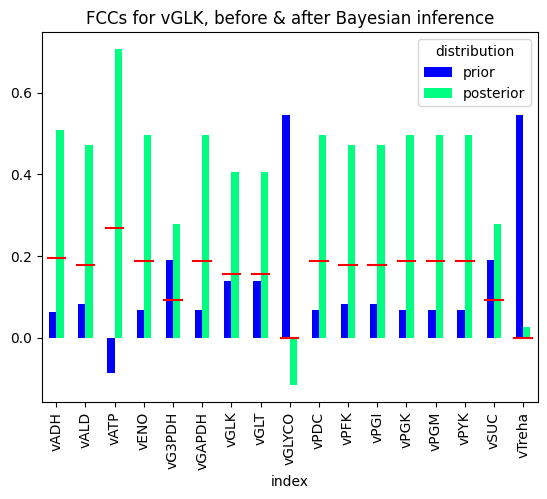

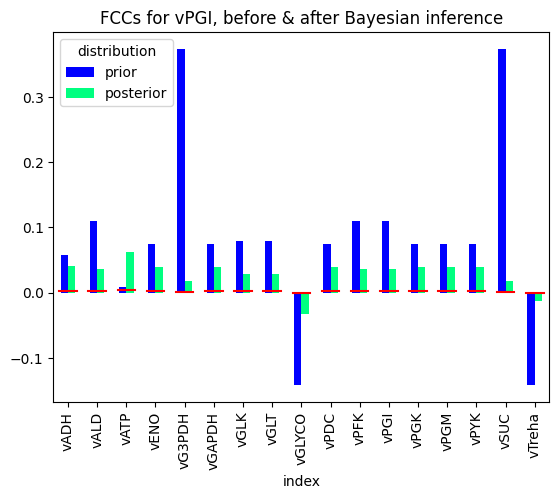

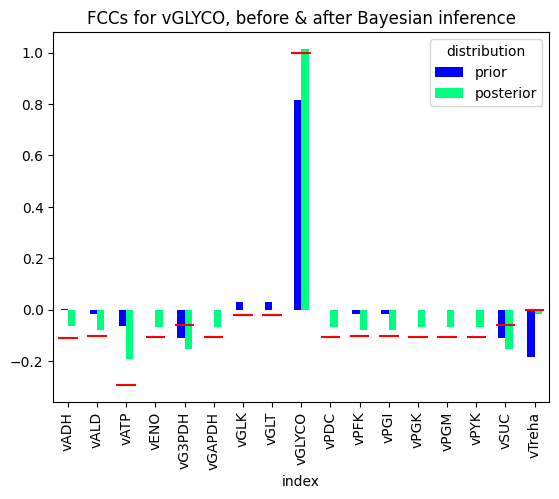

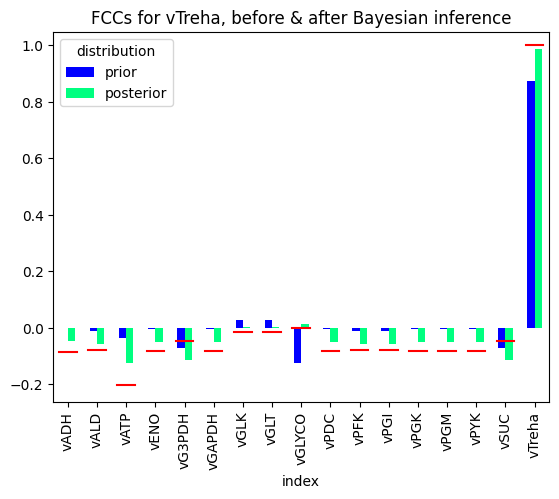

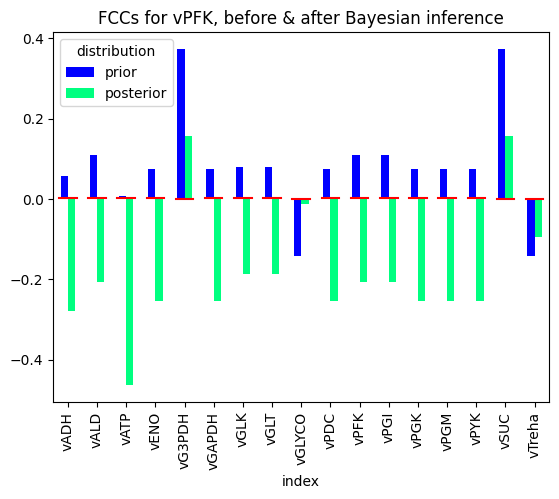

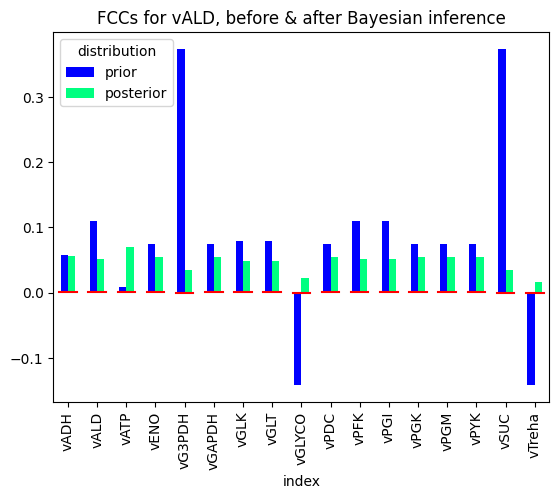

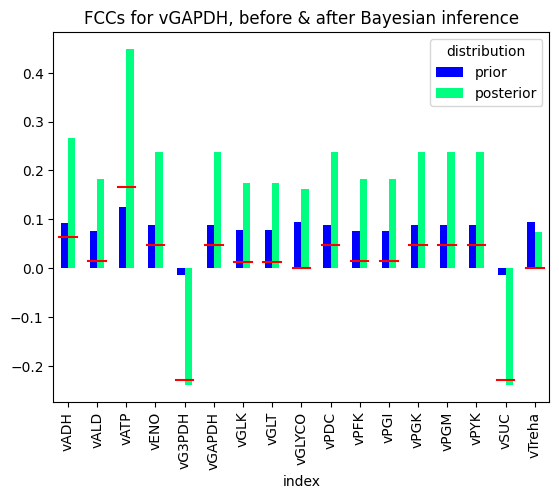

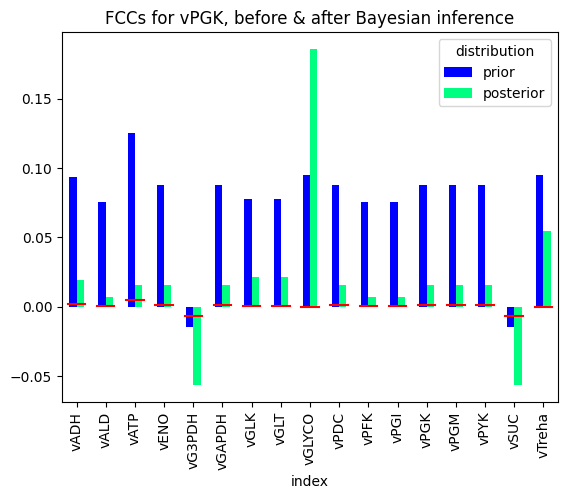

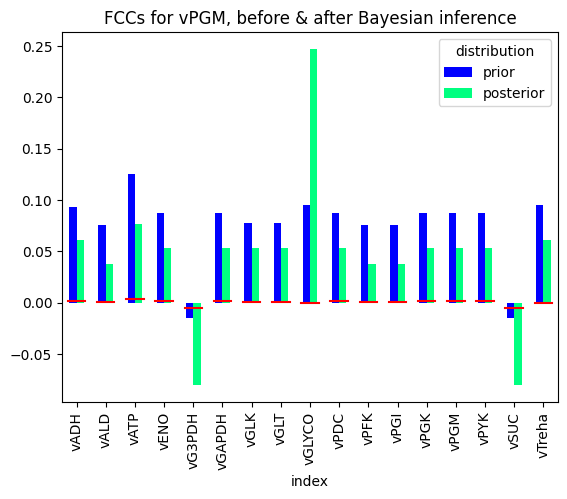

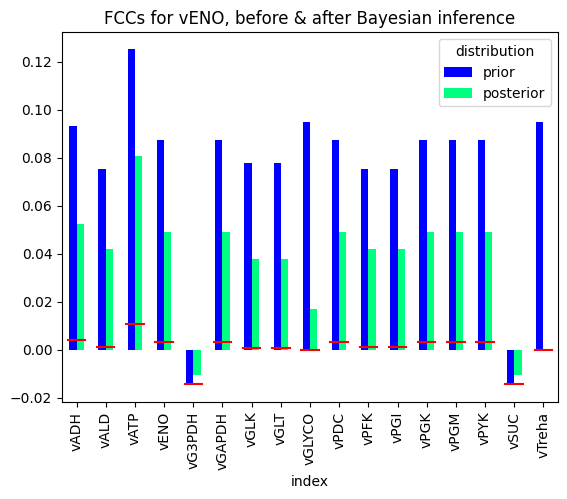

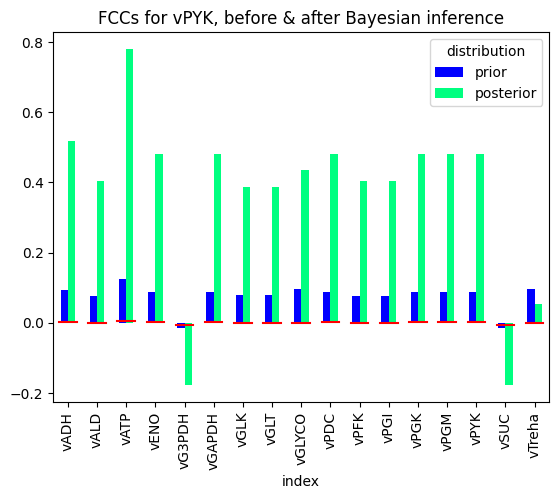

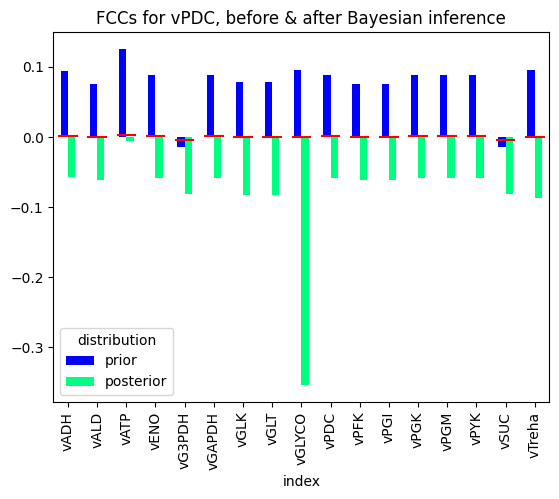

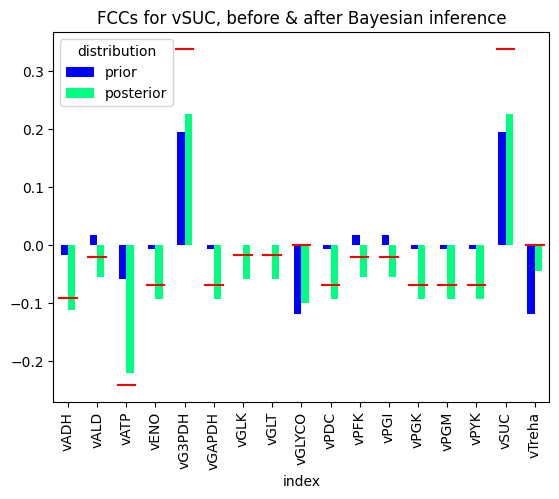

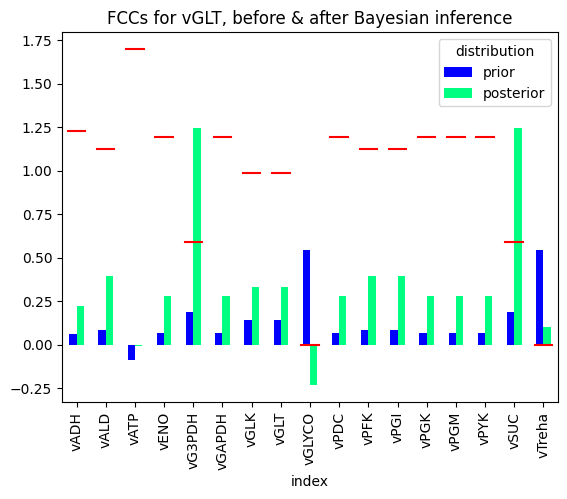

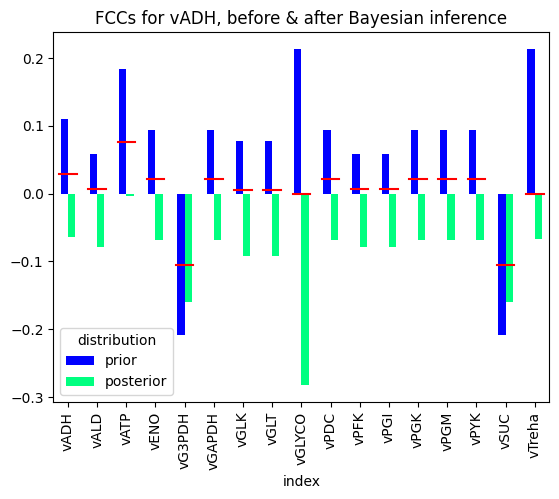

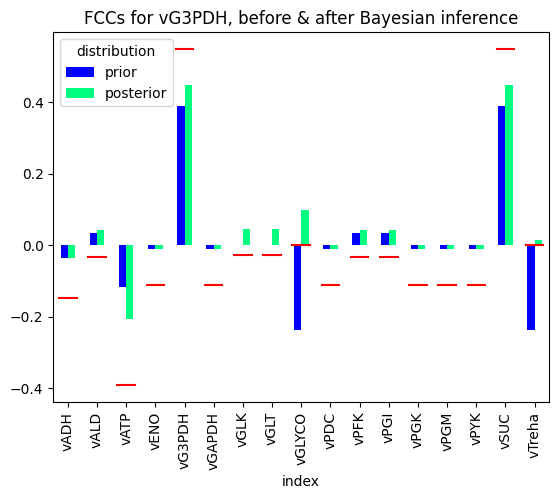

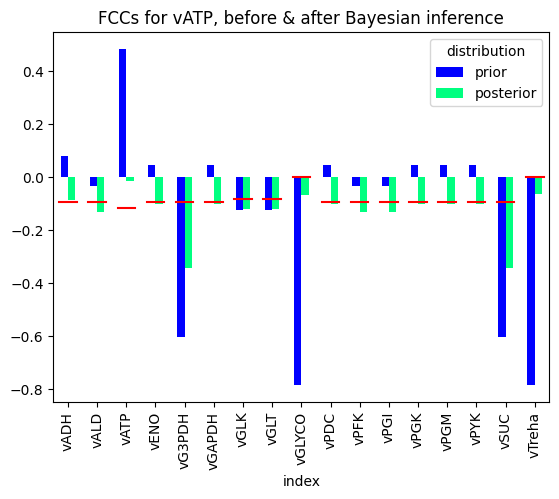

In [32]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

## Ranking FCC values

In [33]:
def rank_FCC_values(yield_enzyme): 
    FCCrankings = pd.concat([gtFCC.loc[yield_enzyme].rank(), visFCC.loc[yield_enzyme].rank(), postFCC.loc[yield_enzyme].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    fig = plt.figure()

    plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
    plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
    plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
    plt.title(f'Comparing scaled flux control coefficient rankings, {yield_enzyme}')
    plt.xlabel('ordinal values from fully parameterized model')
    plt.ylabel('ordinal values from linlog approximations')

    plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
    plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
    plt.text(13,0,'Wilcoxon p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
    plt.legend()

    FCCrankings['visE_dif'] = FCCrankings['visE'] - FCCrankings['gt']
    FCCrankings['postE_dif'] = FCCrankings['postE'] - FCCrankings['gt']
    FCCrankings.sort_values('gt')[['visE_dif','postE_dif']].plot(kind='bar', align='edge', width=0.7, alpha=0.7)
    plt.title(f'Rankings of FCC values for {yield_enzyme} predicted by Bayesian inference')
    plt.xlabel("reactions in order of gt FCC ranking")
    plt.ylabel("FCC ranking")

    return FCCrankings.sort_values('gt')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



,gt,visE,postE,visE_dif,postE_dif
vG3PDH,1.0,1.0,8.0,0.0,7.0
vGLYCO,2.0,4.0,5.0,2.0,3.0
vATP,3.0,5.0,2.0,2.0,-1.0
vTreha,4.0,3.0,7.0,-1.0,3.0
vSUC,5.0,2.0,3.0,-3.0,-2.0
vALD,6.0,9.0,13.0,3.0,7.0
vPDC,7.0,13.0,6.0,6.0,-1.0
vPGM,8.0,15.0,12.0,7.0,4.0
vPGK,9.0,12.0,9.0,3.0,0.0
vPYK,10.0,14.0,16.0,4.0,6.0


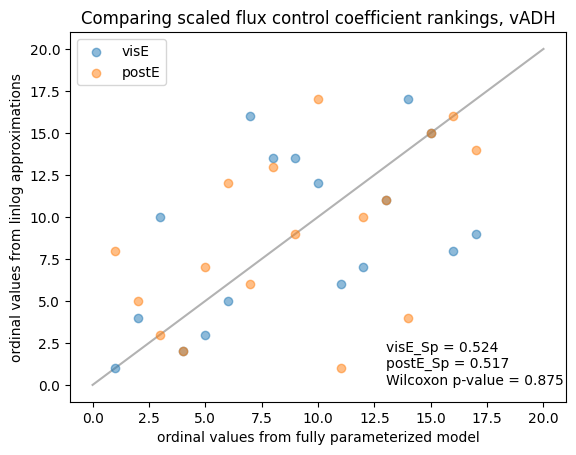

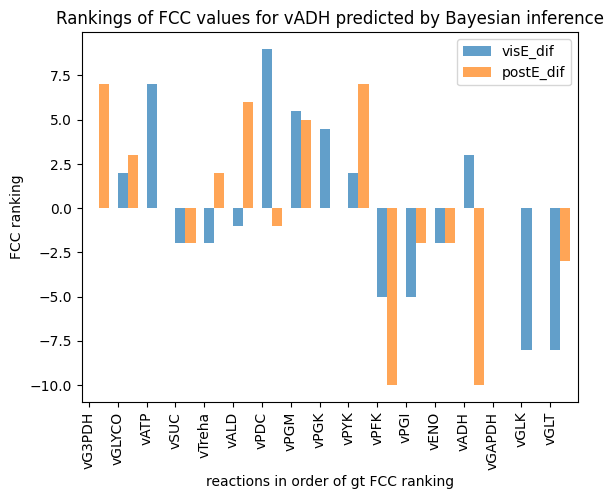

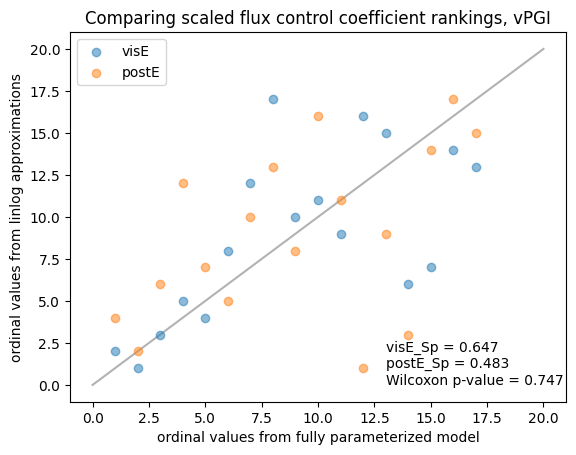

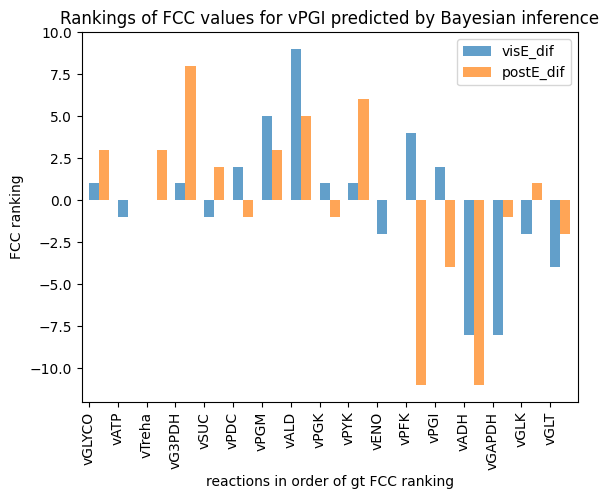

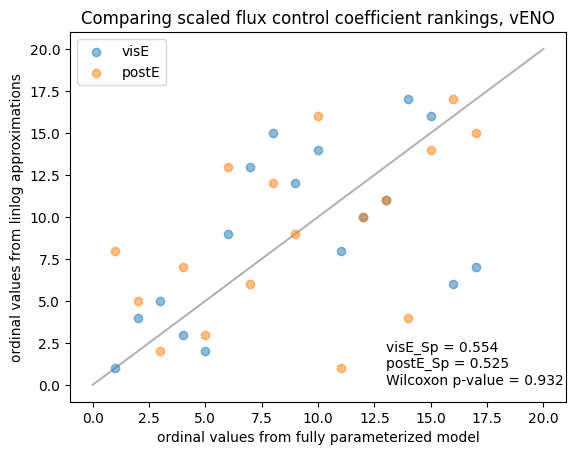

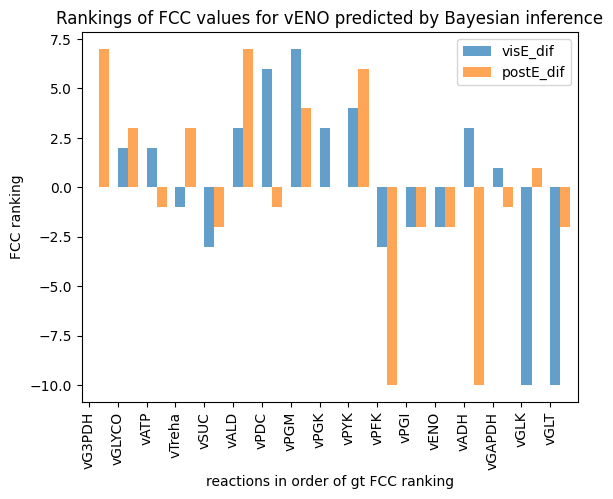

In [34]:
rank_FCC_values('vADH')
rank_FCC_values('vPGI')
rank_FCC_values('vENO')

## Distribution of FCC Sp. correlation coefficients

In [35]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


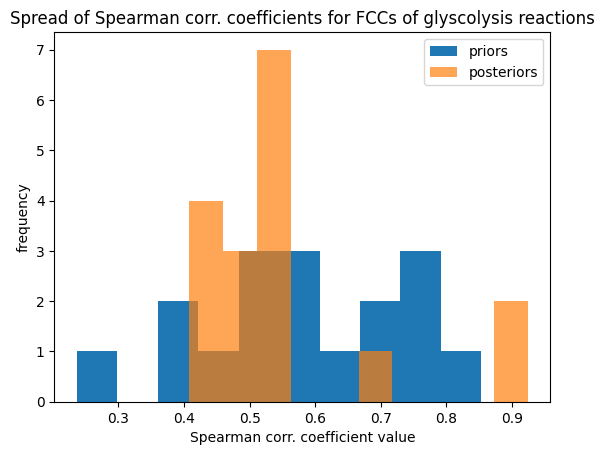

In [36]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()
